#取得資料

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-11-29 14:02:14--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.109.118, 54.231.164.96, 52.217.75.14, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.109.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.37MB/s    in 2.4s    

2022-11-29 14:02:18 (5.37 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


#查看資料

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


#數據分析

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

#畫圖查看

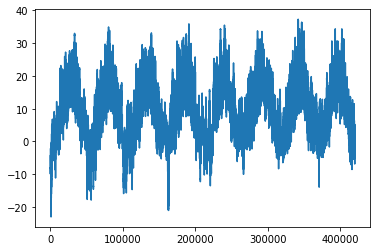

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

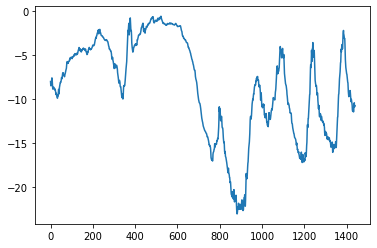

In [5]:
plt.plot(range(1440), temperature[:1440])


In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


#準備資料

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

#檢查數據的輸出

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


#開始訓練

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 56ms/step - loss: 12.6658 - mae: 2.7568 - val_loss: 10.3519 - val_mae: 2.5485
Epoch 2/10
819/819 [==============================] - 44s 53ms/step - loss: 9.3643 - mae: 2.4057 - val_loss: 14.0814 - val_mae: 2.9695
Epoch 3/10
819/819 [==============================] - 42s 50ms/step - loss: 8.6617 - mae: 2.3159 - val_loss: 10.1889 - val_mae: 2.5255
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 8.1976 - mae: 2.2543 - val_loss: 10.4467 - val_mae: 2.5571
Epoch 5/10
819/819 [==============================] - 40s 48ms/step - loss: 7.8391 - mae: 2.2077 - val_loss: 10.7913 - val_mae: 2.6083
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 7.5745 - mae: 2.1737 - val_loss: 10.4277 - val_mae: 2.5598
Epoch 7/10
819/819 [==============================] - 40s 49ms/step - loss: 7.3329 - mae: 2.1409 - val_loss: 10.3276 - val_mae: 2.5362
Epoch 8/10
819/819 [==============================] - 

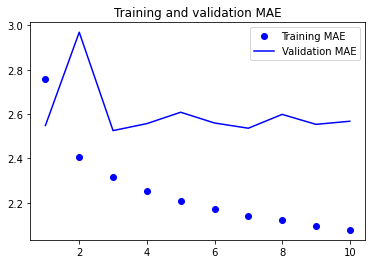

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

#MAE

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 53ms/step - loss: 21.2704 - mae: 3.6075 - val_loss: 14.9717 - val_mae: 3.0775
Epoch 2/10
819/819 [==============================] - 41s 50ms/step - loss: 14.7982 - mae: 3.0500 - val_loss: 14.7715 - val_mae: 3.0272
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 13.5154 - mae: 2.9141 - val_loss: 18.8354 - val_mae: 3.4355
Epoch 4/10
819/819 [==============================] - 42s 51ms/step - loss: 12.6182 - mae: 2.8125 - val_loss: 15.2521 - val_mae: 3.0551
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 12.0278 - mae: 2.7449 - val_loss: 17.4923 - val_mae: 3.3040
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 11.4684 - mae: 2.6780 - val_loss: 15.4828 - val_mae: 3.1133
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 11.1303 - mae: 2.6359 - val_loss: 14.7567 - val_mae: 3.0194
Epoch 8/10
819/819 [============================

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 54ms/step - loss: 43.7622 - mae: 4.8343 - val_loss: 14.1387 - val_mae: 2.8010
Epoch 2/10
819/819 [==============================] - 44s 54ms/step - loss: 11.3325 - mae: 2.6100 - val_loss: 9.7356 - val_mae: 2.4261
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 9.8559 - mae: 2.4527 - val_loss: 9.6533 - val_mae: 2.4168
Epoch 4/10
819/819 [==============================] - 45s 54ms/step - loss: 9.4398 - mae: 2.3984 - val_loss: 9.8321 - val_mae: 2.4386
Epoch 5/10
819/819 [==============================] - 44s 53ms/step - loss: 9.1897 - mae: 2.3648 - val_loss: 9.8879 - val_mae: 2.4408
Epoch 6/10
819/819 [==============================] - 44s 53ms/step - loss: 8.9884 - mae: 2.3391 - val_loss: 10.0443 - val_mae: 2.4623
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 8.7820 - mae: 2.3110 - val_loss: 9.9804 - val_mae: 2.4504
Epoch 8/10
819/819 [==============================] - 44s 

#RNN implement numpy




In [16]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [17]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [18]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [20]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 338s 410ms/step - loss: 28.7975 - mae: 3.9604 - val_loss: 9.9879 - val_mae: 2.4432
Epoch 2/10
819/819 [==============================] - 338s 413ms/step - loss: 14.9152 - mae: 2.9953 - val_loss: 9.3697 - val_mae: 2.3653
Epoch 3/10
819/819 [==============================] - 340s 414ms/step - loss: 13.9979 - mae: 2.9007 - val_loss: 9.4462 - val_mae: 2.3748
Epoch 4/10
819/819 [==============================] - 337s 412ms/step - loss: 13.3166 - mae: 2.8264 - val_loss: 9.2093 - val_mae: 2.3518
Epoch 5/10
819/819 [==============================] - 341s 417ms/step - loss: 12.8179 - mae: 2.7717 - val_loss: 9.1691 - val_mae: 2.3460
Epoch 6/10
819/819 [==============================] - 335s 409ms/step - loss: 12.3975 - mae: 2.7265 - val_loss: 9.1602 - val_mae: 2.3467
Epoch 7/10
819/819 [==============================] - 335s 409ms/step - loss: 12.0994 - mae: 2.6895 - val_loss: 9.4793 - val_mae: 2.3829
Epoch 8/10
819/819 [=====================

In [22]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
554/819 [===================>..........] - ETA: 3:07 - loss: 31.2508 - mae: 4.1181

KeyboardInterrupt: ignored

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)